In [1]:
%pip install seaborn calmap statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import calmap
from scipy import stats
from sklearn.linear_model import LinearRegression

### Add Akebono to combined dataset

In [2]:
def print_rows_removed(before_count, after_df, step_description, column_to_check=None):
    after_count = len(after_df)
    rows_removed = before_count - after_count
    print(f"{step_description}:")
    print(f"Rows removed: {rows_removed}")
    print(f"Rows remaining: {after_count}")
    
    # If a column is provided, print the new range of that column
    if column_to_check:
        min_value = after_df[column_to_check].min()
        max_value = after_df[column_to_check].max()
        print(f"New range of '{column_to_check}': {min_value} to {max_value}")
    
    print("\n")
    return after_count

# Load the dataset
akebono_file_path = '../data/Akebono_combined.tsv'
df = pd.read_csv(akebono_file_path, sep='\t')

# Convert DateFormatted to datetime if it's not already
df['DateFormatted'] = pd.to_datetime(df['DateFormatted'], errors='coerce')

# Initial row count
initial_row_count = len(df)
print(f"Initial number of rows: {initial_row_count}\n")

# -----------------------------------
# 1. Drop Unnecessary Columns during training
# -----------------------------------
# This step can be done when training the model, specify output and input columns
# -----------------------------------
# 2. Remove Rows with '999' in Specified Columns
# -----------------------------------
columns_with_999 = ['XXLAT', 'XXLON']
mask_999 = (df[columns_with_999] == 999).any(axis=1)
filtered_df = df[~mask_999]

# Check rows removed after step 2 (checking 'GLAT' and 'GMLT' range)
initial_row_count = print_rows_removed(initial_row_count, filtered_df, "After removing rows with '999' values", column_to_check='GLAT')

# -----------------------------------
# 3. Remove Rows Greater Than '90' in 'ILAT'
# -----------------------------------
filtered_df = filtered_df[filtered_df['ILAT'] <= 90]

# Check rows removed after step 3 (checking 'ILAT' range)
initial_row_count = print_rows_removed(initial_row_count, filtered_df, "After removing rows with ILAT > 90", column_to_check='ILAT')

# -----------------------------------
# 4. Filter Data Between 1000km and 8000km Altitude
# -----------------------------------
filtered_df = filtered_df[(filtered_df['Altitude'] >= 1000) & (filtered_df['Altitude'] <= 8000)]

# Check rows removed after step 4 (checking 'Altitude' range)
initial_row_count = print_rows_removed(initial_row_count, filtered_df, "After filtering Altitude between 1000km and 8000km", column_to_check='Altitude')

# -----------------------------------
# 5. Filter Out Rows Before January 1st, 1990
# -----------------------------------
filtered_df['DateFormatted'] = pd.to_datetime(filtered_df['DateFormatted'], errors='coerce')
filtered_df = filtered_df.dropna(subset=['DateFormatted'])
filtered_df = filtered_df[filtered_df['DateFormatted'] >= '1990-01-01']

# Check rows removed after step 5 (checking 'DateFormatted' range)
initial_row_count = print_rows_removed(initial_row_count, filtered_df, "After filtering rows before January 1st, 1990", column_to_check='DateFormatted')

# -----------------------------------
# 6. Combine 'DateFormatted' and 'TimeFormatted' into 'DateTimeFormatted'
# -----------------------------------
# Create the 'DateTimeFormatted' column by combining 'DateFormatted' and 'TimeFormatted' columns
filtered_df['DateTimeFormatted'] = pd.to_datetime(filtered_df['DateFormatted'].dt.strftime('%Y-%m-%d') + ' ' + filtered_df['TimeFormatted'].astype(str), errors='coerce')

# Round the timestamps in filtered_df to the nearest minute to avoid precision issues
filtered_df['DateTimeFormatted'] = filtered_df['DateTimeFormatted'].dt.floor('T')

# Drop the old 'DateFormatted' and 'TimeFormatted' columns
filtered_df = filtered_df.drop(columns=['DateFormatted', 'TimeFormatted', 'Date', 'Time'], errors='ignore')

# Check the first few rows after combining
print("After creating DateTimeFormatted column:")
print(filtered_df[['DateTimeFormatted']].head())

# -----------------------------------
# 7. Initialize 'AL_index' and 'SYM_H' 
# -----------------------------------
if 'AL_index' not in filtered_df.columns:
    filtered_df['AL_index'] = np.nan
if 'SYM_H' not in filtered_df.columns:
    filtered_df['SYM_H'] = np.nan

# -----------------------------------
# Final check and summary
# -----------------------------------
final_row_count = len(filtered_df)
print(f"Final number of rows: {final_row_count}")
print(filtered_df.head())

# You can now proceed to merge this cleaned and transformed 'filtered_df' with the OMNI dataset.


Initial number of rows: 4405241

After removing rows with '999' values:
Rows removed: 133659
Rows remaining: 4271582
New range of 'GLAT': -85.95 to 85.96


After removing rows with ILAT > 90:
Rows removed: 22891
Rows remaining: 4248691
New range of 'ILAT': 19.91 to 85.0


After filtering Altitude between 1000km and 8000km:
Rows removed: 890557
Rows remaining: 3358134
New range of 'Altitude': 1000.0 to 8000.0


After filtering rows before January 1st, 1990:
Rows removed: 98304
Rows remaining: 3259830
New range of 'DateFormatted': 1990-01-08 00:00:00 to 2001-12-30 00:00:00




/tmp/ipykernel_1445370/3245502886.py:75: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  filtered_df['DateTimeFormatted'] = filtered_df['DateTimeFormatted'].dt.floor('T')


After creating DateTimeFormatted column:
         DateTimeFormatted
150023 1990-01-08 12:05:00
150024 1990-01-08 12:07:00
150025 1990-01-08 12:08:00
150220 1990-01-08 17:05:00
150221 1990-01-08 17:05:00
Final number of rows: 3259830
        Altitude  GCLAT  GCLON   ILAT   GLAT   GMLT  XXLAT  XXLON   Te1   Ne1  \
150023    6760.0  79.89  134.7  73.58  64.28  20.43  73.63   20.5   843   269   
150024    7003.0  79.54  143.2  73.40  63.95  20.81  73.45   20.9  1695   701   
150025    7175.0  79.18  148.7  73.19  63.57  21.07  73.24   21.2  2931   590   
150220    7998.0 -36.07  129.5  47.93  -8.72   1.74 -48.83    1.7  3816  3399   
150221    7985.0 -36.07  129.5  47.92  -8.85   1.74 -48.83    1.7  3881  3647   

        ...   Pv2   Te3   Ne3   Pv3  I1  I2  I3   DateTimeFormatted  AL_index  \
150023  ...  0.00     0     0  0.00  52   0   0 1990-01-08 12:05:00       NaN   
150024  ...  0.00     0     0  0.00  54   0   0 1990-01-08 12:07:00       NaN   
150025  ...  0.00     0     0  0.00  

#Add Magnetic Field, plasma, solar indices, particle data

In [4]:

# Parse into datetime object
filtered_df['DateTimeFormatted'] = pd.to_datetime(filtered_df['DateTimeFormatted'], format='%Y-%m-%d %H:%M:%S')

# Read the single OMNI data file
omni_file_path = '../data/omni_magnetic_plasma_solar/omni2_K1CK9l7koS.lst'

# Define column names
columns = [
    'Year', 'Day', 'Hour', 
    'Mag_Scalar_B', 'Mag_Vector_B', 'Mag_B_Lat_GSE', 'Mag_B_Long_GSE',
    'Mag_BX_GSE', 'Mag_BY_GSE', 'Mag_BZ_GSE', 'Mag_BY_GSM', 'Mag_BZ_GSM', 
    'Mag_RMS_Mag', 'Mag_RMS_Vector', 'Mag_RMS_BX_GSE', 'Mag_RMS_BY_GSE', 'Mag_RMS_BZ_GSE',
    'Plasma_SW_Temp', 'Plasma_SW_Density', 'Plasma_SW_Speed',
    'Plasma_SW_Flow_Long', 'Plasma_SW_Flow_Lat', 'Plasma_Alpha_Prot_Ratio', 
    'Plasma_Sigma_T', 'Plasma_Sigma_N', 'Plasma_Sigma_V', 
    'Plasma_Sigma_Phi_V', 'Plasma_Sigma_Theta_V', 'Plasma_Sigma_Ratio',
    'Solar_Kp', 'Solar_R_Sunspot', 'Solar_Dst', 'Solar_Ap', 
    'Solar_AE', 'Solar_AL', 'Solar_AU', 'Solar_PC',
    'Solar_Lyman_Alpha',
    'Particle_Proton_Flux_1MeV', 'Particle_Proton_Flux_2MeV', 
    'Particle_Proton_Flux_4MeV', 'Particle_Proton_Flux_10MeV', 
    'Particle_Proton_Flux_30MeV', 'Particle_Proton_Flux_60MeV',
    'Particle_Flux_Flag'
]

# Read the OMNI data file
omni_df = pd.read_csv(omni_file_path, delim_whitespace=True, names=columns)

# Create the 'DateTime' column from Year, Day of Year, Hour, and Minute
omni_df['DateTime'] = pd.to_datetime(omni_df['Year'] * 1000 + omni_df['Day'], format='%Y%j') \
                 + pd.to_timedelta(omni_df['Hour'], unit='h')

# Keep only the necessary columns
omni_df = omni_df[['DateTime', 'Mag_Scalar_B', 'Mag_Vector_B', 'Mag_B_Lat_GSE', 'Mag_B_Long_GSE',
         'Mag_BX_GSE', 'Mag_BY_GSE', 'Mag_BZ_GSE', 'Mag_BY_GSM', 'Mag_BZ_GSM', 
         'Mag_RMS_Mag', 'Mag_RMS_Vector', 'Mag_RMS_BX_GSE', 'Mag_RMS_BY_GSE', 'Mag_RMS_BZ_GSE',
         'Plasma_SW_Temp', 'Plasma_SW_Density', 'Plasma_SW_Speed',
         'Plasma_SW_Flow_Long', 'Plasma_SW_Flow_Lat', 'Plasma_Alpha_Prot_Ratio', 
         'Plasma_Sigma_T', 'Plasma_Sigma_N', 'Plasma_Sigma_V', 
         'Plasma_Sigma_Phi_V', 'Plasma_Sigma_Theta_V', 'Plasma_Sigma_Ratio',
         'Solar_Kp', 'Solar_R_Sunspot', 'Solar_Dst', 'Solar_Ap', 
         'Solar_AE', 'Solar_AL', 'Solar_AU', 'Solar_PC',
         'Solar_Lyman_Alpha',
         'Particle_Proton_Flux_1MeV', 'Particle_Proton_Flux_2MeV', 
         'Particle_Proton_Flux_4MeV', 'Particle_Proton_Flux_10MeV', 
         'Particle_Proton_Flux_30MeV', 'Particle_Proton_Flux_60MeV',
         'Particle_Flux_Flag']]

# Reset index to make 'DateTime' a column
omni_df.reset_index(drop=True, inplace=True)
omni_df = omni_df.drop_duplicates(subset='DateTime', keep='first')
omni_df.set_index('DateTime', inplace=True)
filtered_df['DateTimeFormatted_copy'] = filtered_df['DateTimeFormatted']
filtered_df['DateTimeFormatted'] = filtered_df['DateTimeFormatted'].dt.round('H')
filtered_df.set_index('DateTimeFormatted', inplace=True)
filtered_df.sort_index(inplace=True)
omni_df.sort_index(inplace=True)
for col in omni_df.columns:
    if col not in ['DateTime', 'Particle_Flux_Flag']:
        omni_df[col] = omni_df[col].fillna(omni_df[col])
        # Check for exact fill value patterns and create existence column
        fill_values = ['999.9', '9.999', '9999.0', '99999.99','99999.99', '9999999', '9999999.0']
        omni_df[f'exists_{col}'] = (~omni_df[col].astype(str).isin(fill_values)).astype(int)


# Now, fill NaN values in 'filtered_df' with corresponding values from 'aligned_omni'
for col in ['Mag_Scalar_B', 'Mag_Vector_B', 'Mag_B_Lat_GSE', 'Mag_B_Long_GSE',
            'Mag_BX_GSE', 'Mag_BY_GSE', 'Mag_BZ_GSE', 'Mag_BY_GSM', 'Mag_BZ_GSM', 
            'Mag_RMS_Mag', 'Mag_RMS_Vector', 'Mag_RMS_BX_GSE', 'Mag_RMS_BY_GSE', 'Mag_RMS_BZ_GSE',
            'Plasma_SW_Temp', 'Plasma_SW_Density', 'Plasma_SW_Speed',
            'Plasma_SW_Flow_Long', 'Plasma_SW_Flow_Lat', 'Plasma_Alpha_Prot_Ratio', 
            'Plasma_Sigma_T', 'Plasma_Sigma_N', 'Plasma_Sigma_V', 
            'Plasma_Sigma_Phi_V', 'Plasma_Sigma_Theta_V', 'Plasma_Sigma_Ratio',
            'Solar_Kp', 'Solar_R_Sunspot', 'Solar_Dst', 'Solar_Ap', 
            'Solar_AE', 'Solar_AL', 'Solar_AU', 'Solar_PC',
            'Solar_Lyman_Alpha',
            'Particle_Proton_Flux_1MeV', 'Particle_Proton_Flux_2MeV', 
            'Particle_Proton_Flux_4MeV', 'Particle_Proton_Flux_10MeV', 
            'Particle_Proton_Flux_30MeV', 'Particle_Proton_Flux_60MeV', 'Particle_Flux_Flag',
            'exists_Mag_Scalar_B', 'exists_Mag_Vector_B', 'exists_Mag_B_Lat_GSE', 'exists_Mag_B_Long_GSE',
            'exists_Mag_BX_GSE', 'exists_Mag_BY_GSE', 'exists_Mag_BZ_GSE', 'exists_Mag_BY_GSM', 'exists_Mag_BZ_GSM', 
            'exists_Mag_RMS_Mag', 'exists_Mag_RMS_Vector', 'exists_Mag_RMS_BX_GSE', 'exists_Mag_RMS_BY_GSE', 'exists_Mag_RMS_BZ_GSE',
            'exists_Plasma_SW_Temp', 'exists_Plasma_SW_Density', 'exists_Plasma_SW_Speed',
            'exists_Plasma_SW_Flow_Long', 'exists_Plasma_SW_Flow_Lat', 'exists_Plasma_Alpha_Prot_Ratio', 
            'exists_Plasma_Sigma_T', 'exists_Plasma_Sigma_N', 'exists_Plasma_Sigma_V', 
            'exists_Plasma_Sigma_Phi_V', 'exists_Plasma_Sigma_Theta_V', 'exists_Plasma_Sigma_Ratio',
            'exists_Solar_Kp', 'exists_Solar_R_Sunspot', 'exists_Solar_Dst', 'exists_Solar_Ap', 
            'exists_Solar_AE', 'exists_Solar_AL', 'exists_Solar_AU', 'exists_Solar_PC',
            'exists_Solar_Lyman_Alpha',
            'exists_Particle_Proton_Flux_1MeV', 'exists_Particle_Proton_Flux_2MeV', 
            'exists_Particle_Proton_Flux_4MeV', 'exists_Particle_Proton_Flux_10MeV', 
            'exists_Particle_Proton_Flux_30MeV', 'exists_Particle_Proton_Flux_60MeV']: # 83
    if col not in filtered_df.columns:
        filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)
    filtered_df[col] = filtered_df[col].fillna(omni_df[col])

# Reset the index if you want to keep 'DateTimeFormatted' as a column
filtered_df.reset_index(inplace=True)

/tmp/ipykernel_1445370/3438355974.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  omni_df = pd.read_csv(omni_file_path, delim_whitespace=True, names=columns)
/tmp/ipykernel_1445370/3438355974.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  filtered_df['DateTimeFormatted'] = filtered_df['DateTimeFormatted'].dt.round('H')


In [14]:
filtered_df = og
# Create a copy of the DateTimeFormatted column
filtered_df['DateTimeFormatted_copy'] = filtered_df.index

# Reset the index to remove DateTimeFormatted as the index
filtered_df.reset_index(inplace=True)

# Set DateTimeFormatted_copy as the new index
filtered_df.set_index('DateTimeFormatted_copy', inplace=True)

# Rename the index to match the original name
filtered_df.index.name = 'DateTimeFormatted'

# Drop the original DateTimeFormatted column
filtered_df.drop('DateTimeFormatted', axis=1, inplace=True)

filtered_df


,Altitude,GCLAT,GCLON,ILAT,GLAT,GMLT,XXLAT,XXLON,Te1,Ne1,...,exists_Solar_AL,exists_Solar_AU,exists_Solar_PC,exists_Solar_Lyman_Alpha,exists_Particle_Proton_Flux_1MeV,exists_Particle_Proton_Flux_2MeV,exists_Particle_Proton_Flux_4MeV,exists_Particle_Proton_Flux_10MeV,exists_Particle_Proton_Flux_30MeV,exists_Particle_Proton_Flux_60MeV
DateTimeFormatted,,,,,,,,,,,,,,,,,,,,,
1990-01-08 12:05:00,6760.0,79.89,134.7,73.58,64.28,20.43,73.63,20.5,843,269,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1990-01-08 12:07:00,7003.0,79.54,143.2,73.40,63.95,20.81,73.45,20.9,1695,701,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1990-01-08 12:08:00,7175.0,79.18,148.7,73.19,63.57,21.07,73.24,21.2,2931,590,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1990-01-08 17:05:00,7998.0,-36.07,129.5,47.93,-8.72,1.74,-48.83,1.7,3816,3399,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1990-01-08 17:05:00,7985.0,-36.07,129.5,47.92,-8.85,1.74,-48.83,1.7,3881,3647,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-12-30 04:57:00,3509.0,37.96,300.0,48.08,33.52,1.33,47.12,1.6,4484,1755,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2001-12-30 04:57:00,3492.0,37.76,300.1,47.89,33.25,1.34,46.92,1.6,4484,2102,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2001-12-30 04:57:00,3476.0,37.56,300.1,47.70,32.97,1.34,46.71,1.6,4292,2254,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# More 1 min data
# Read all .lst files from the directory
file_list = glob.glob('../data/omni_1min/*.txt')

df_list = []

for file in file_list:
    # Define column names
    columns = ['Year', 'Day', 'Hour', 'Minute',
               'BSN_X_GSE', 'BSN_Y_GSE', 'BSN_Z_GSE',
               'AE_index', 'AU_index', 'SYM_D', 'ASY_D', 'ASY_H', 'PCN_index']
    
    # Read the OMNI data file
    df = pd.read_csv(file, delim_whitespace=True, names=columns)
    
    # Create the 'DateTime' column from Year, Day of Year, Hour, and Minute
    df['DateTime'] = pd.to_datetime(df['Year'] * 1000 + df['Day'], format='%Y%j') \
                     + pd.to_timedelta(df['Hour'], unit='h') \
                     + pd.to_timedelta(df['Minute'], unit='m')
    
    # Keep only the necessary columns
    df = df[['DateTime', 'BSN_X_GSE', 'BSN_Y_GSE', 'BSN_Z_GSE',
               'AE_index', 'AU_index', 'SYM_D', 'ASY_D', 'ASY_H', 'PCN_index']]
    
    df_list.append(df)
# Concatenate all OMNI DataFrames into one
omni_df = pd.concat(df_list, ignore_index=True)

# Reset index to make 'DateTime' a column
omni_df.reset_index(drop=True, inplace=True)
omni_df = omni_df.drop_duplicates(subset='DateTime', keep='first')
omni_df.set_index('DateTime', inplace=True)
filtered_df.sort_index(inplace=True)
omni_df.sort_index(inplace=True)
for col in omni_df.columns:
    if col not in ['DateTime']:
        omni_df[col] = omni_df[col].fillna(omni_df[col])
        # Check for exact fill value patterns and create existence column
        fill_values = ['999.9', '9.999', '9999.0', '9999.99', '99999.99','99999.99', '9999999', '9999999.0']
        omni_df[f'exists_{col}'] = (~omni_df[col].astype(str).isin(fill_values)).astype(int)
        

# Now, fill NaN values in 'filtered_df' with corresponding values from 'aligned_omni'
for col in ['BSN_X_GSE', 'BSN_Y_GSE', 'BSN_Z_GSE', 'AE_index', 'AU_index', 'SYM_D',
       'ASY_D', 'ASY_H', 'PCN_index', 'exists_BSN_X_GSE', 'exists_BSN_Y_GSE',
       'exists_BSN_Z_GSE', 'exists_AE_index', 'exists_AU_index',
       'exists_SYM_D', 'exists_ASY_D', 'exists_ASY_H', 'exists_PCN_index']:
    if col not in filtered_df.columns:
        filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)
    filtered_df[col] = filtered_df[col].fillna(omni_df[col])
    print(f"{col}: {filtered_df[col].min()} to {filtered_df[col].max()}")

# Reset the index if you want to keep 'DateTimeFormatted' as a column
filtered_df.reset_index(inplace=True)

/tmp/ipykernel_1445370/777384237.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, names=columns)


/tmp/ipykernel_1445370/777384237.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, names=columns)
/tmp/ipykernel_1445370/777384237.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, names=columns)
/tmp/ipykernel_1445370/777384237.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, names=columns)
/tmp/ipykernel_1445370/777384237.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, names=columns)
/tmp/ipykernel_14453

BSN_X_GSE: 4.31 to 9999.99
BSN_Y_GSE: -6.39 to 9999.99
BSN_Z_GSE: -5.98 to 9999.99
AE_index: 4.0 to 3296.0
AU_index: -411.0 to 1261.0
SYM_D: -70.0 to 122.0
ASY_D: 0.0 to 480.0
ASY_H: 1.0 to 555.0


/tmp/ipykernel_1445370/777384237.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)
/tmp/ipykernel_1445370/777384237.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)


PCN_index: -22.26 to 999.99
exists_BSN_X_GSE: 0.0 to 1.0


/tmp/ipykernel_1445370/777384237.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)
/tmp/ipykernel_1445370/777384237.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)


exists_BSN_Y_GSE: 0.0 to 1.0
exists_BSN_Z_GSE: 0.0 to 1.0


/tmp/ipykernel_1445370/777384237.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)
/tmp/ipykernel_1445370/777384237.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)


exists_AE_index: 1.0 to 1.0
exists_AU_index: 1.0 to 1.0


/tmp/ipykernel_1445370/777384237.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)
/tmp/ipykernel_1445370/777384237.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)


exists_SYM_D: 1.0 to 1.0
exists_ASY_D: 1.0 to 1.0


/tmp/ipykernel_1445370/777384237.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)
/tmp/ipykernel_1445370/777384237.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)


exists_ASY_H: 1.0 to 1.0
exists_PCN_index: 1.0 to 1.0


/tmp/ipykernel_1445370/777384237.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df[col] = pd.Series(np.nan, index=filtered_df.index)
/tmp/ipykernel_1445370/777384237.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df.reset_index(inplace=True)


In [17]:
og2 = filtered_df

### Add Al index and SYM/H to combined dataset

In [18]:
# Parse into datetime object
filtered_df['DateTimeFormatted'] = pd.to_datetime(filtered_df['DateTimeFormatted'], format='%y%m%d%H%M%S')

# Ensure 'DateTimeFormatted' is a datetime object
filtered_df['DateTimeFormatted'] = pd.to_datetime(filtered_df['DateTimeFormatted'])

# Step 2: Read and Concatenate OMNI Data Files

# Read all .lst files from the directory
file_list = glob.glob('../data/omni_al_index_symh/*.lst')

df_list = []

for file in file_list:
    # Define column names
    columns = ['Year', 'Day', 'Hour', 'Minute', 'AL_index', 'SYM_H']
    
    # Read the OMNI data file
    df = pd.read_csv(file, delim_whitespace=True, names=columns)
    
    # Create the 'DateTime' column from Year, Day of Year, Hour, and Minute
    df['DateTime'] = pd.to_datetime(df['Year'] * 1000 + df['Day'], format='%Y%j') \
                     + pd.to_timedelta(df['Hour'], unit='h') \
                     + pd.to_timedelta(df['Minute'], unit='m')
    
    # Keep only the necessary columns
    df = df[['DateTime', 'AL_index', 'SYM_H']]
    
    df_list.append(df)

# Concatenate all OMNI DataFrames into one
omni_df = pd.concat(df_list, ignore_index=True)

# Step 3: Remove Duplicates in omni_df by Keeping the First Occurrence

# Reset index to make 'DateTime' a column
omni_df.reset_index(drop=True, inplace=True)

# Drop duplicates based on 'DateTime', keep the first occurrence
omni_df = omni_df.drop_duplicates(subset='DateTime', keep='first')

# Set 'DateTime' as the index
omni_df.set_index('DateTime', inplace=True)

# Step 4: Merge the DataFrames

# Set 'DateTimeFormatted' as the index in filtered_df
filtered_df.set_index('DateTimeFormatted', inplace=True)

# Ensure the indices are sorted (optional but recommended)
filtered_df.sort_index(inplace=True)
omni_df.sort_index(inplace=True)

# Step 5: Align and Fill NaN Values in filtered_df

# Align the OMNI data to the filtered_df index
aligned_omni = omni_df.reindex(filtered_df.index)

# Now, fill NaN values in 'filtered_df' with corresponding values from 'aligned_omni'
for col in ['AL_index', 'SYM_H']:
    filtered_df[col] = filtered_df[col].fillna(aligned_omni[col])

# Reset the index if you want to keep 'DateTimeFormatted' as a column
filtered_df.reset_index(inplace=True)

# Now, filtered_df has the 'AL_index' and 'SYM_H' columns filled in where data is available
print(filtered_df)


/tmp/ipykernel_1445370/779585240.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, names=columns)
/tmp/ipykernel_1445370/779585240.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, names=columns)
/tmp/ipykernel_1445370/779585240.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, names=columns)
/tmp/ipykernel_1445370/779585240.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, names=columns)
/tmp/ipykernel_14453

          DateTimeFormatted  Altitude  GCLAT  GCLON   ILAT   GLAT   GMLT  \
0       1990-01-08 12:05:00    6760.0  79.89  134.7  73.58  64.28  20.43   
1       1990-01-08 12:07:00    7003.0  79.54  143.2  73.40  63.95  20.81   
2       1990-01-08 12:08:00    7175.0  79.18  148.7  73.19  63.57  21.07   
3       1990-01-08 17:05:00    7998.0 -36.07  129.5  47.93  -8.72   1.74   
4       1990-01-08 17:05:00    7985.0 -36.07  129.5  47.92  -8.85   1.74   
...                     ...       ...    ...    ...    ...    ...    ...   
3259825 2001-12-30 04:57:00    3509.0  37.96  300.0  48.08  33.52   1.33   
3259826 2001-12-30 04:57:00    3492.0  37.76  300.1  47.89  33.25   1.34   
3259827 2001-12-30 04:57:00    3476.0  37.56  300.1  47.70  32.97   1.34   
3259828 2001-12-30 04:57:00    3459.0  37.37  300.2  47.51  32.70   1.35   
3259829 2001-12-30 04:57:00    3442.0  37.17  300.2  47.32  32.43   1.35   

         XXLAT  XXLON   Te1  ...  PCN_index  exists_BSN_X_GSE  \
0        73.63   20.5 

Total number of rows: 3259830
Number of rows with missing AL_index: 0
Number of rows with missing SYM_H: 0
Number of rows with missing either AL_index or SYM_H: 0

Number of missing entries per month:
Series([], Freq: M, Name: DateTimeFormatted, dtype: int64)


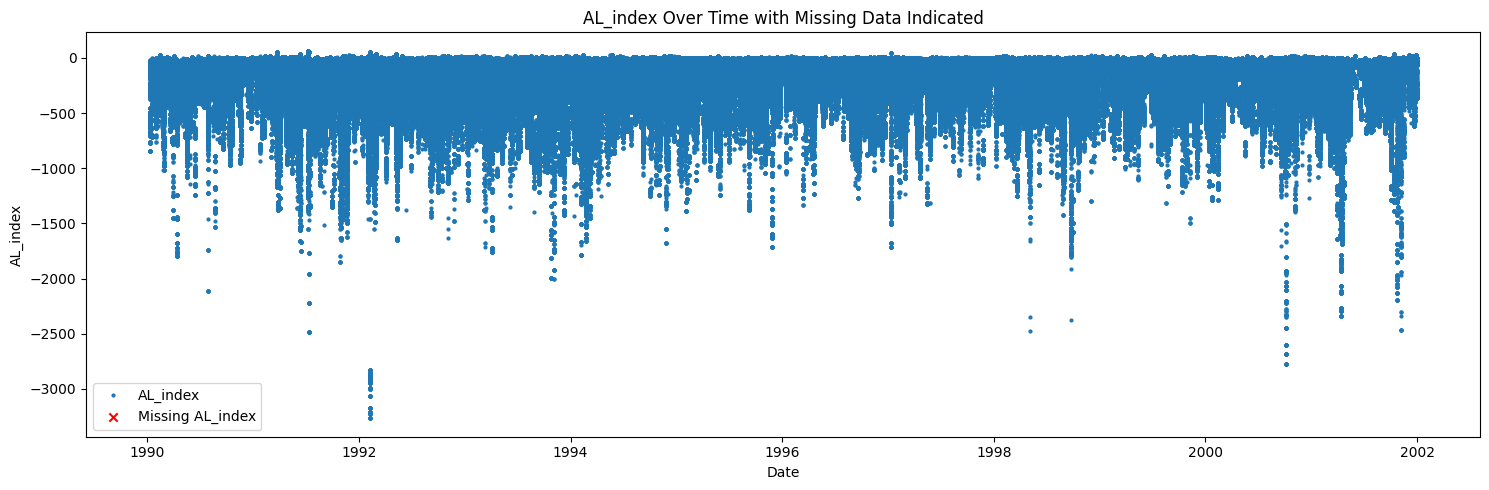

In [19]:
# --- Begin of Statistical Analysis and Visualization ---

# Step 1: Check for NaN values in 'AL_index' and 'SYM_H'
missing_al_index_mask = filtered_df['AL_index'].isna()
missing_sym_h_mask = filtered_df['SYM_H'].isna()
missing_either_mask = missing_al_index_mask | missing_sym_h_mask

# Total counts of missing values
total_rows = len(filtered_df)
missing_al_index_count = missing_al_index_mask.sum()
missing_sym_h_count = missing_sym_h_mask.sum()
missing_either_count = missing_either_mask.sum()

print(f"Total number of rows: {total_rows}")
print(f"Number of rows with missing AL_index: {missing_al_index_count}")
print(f"Number of rows with missing SYM_H: {missing_sym_h_count}")
print(f"Number of rows with missing either AL_index or SYM_H: {missing_either_count}")

# Step 2: Statistical Analysis of NaN Occurrences by Month
# Extract the timestamps with missing data
missing_dates = filtered_df.loc[missing_either_mask, 'DateTimeFormatted']

# Group missing data by month
missing_counts_monthly = missing_dates.groupby(missing_dates.dt.to_period('M')).count()

print("\nNumber of missing entries per month:")
print(missing_counts_monthly)

# Step 3: Visualization of Missing Values

# 3.1 Timeline Plot of Missing Values
plt.figure(figsize=(15, 5))
plt.plot(filtered_df['DateTimeFormatted'], filtered_df['AL_index'], label='AL_index', marker='o', linestyle='None', markersize=2)
plt.scatter(filtered_df.loc[missing_al_index_mask, 'DateTimeFormatted'], [0]*missing_al_index_mask.sum(), color='red', label='Missing AL_index', marker='x')
plt.xlabel('Date')
plt.ylabel('AL_index')
plt.title('AL_index Over Time with Missing Data Indicated')
plt.legend()
plt.tight_layout()
plt.show()

### Add F10.7 to combined dataset

In [21]:
# Assuming 'filtered_df' has already been created as per your pipeline

# --- Step 1: Parse f107 data and add to filtered_df ---

# Step 1: Read and Concatenate f107 Data Files
# Read all f107 .lst files from the directory (replace with your actual directory)
f107_file_list = glob.glob('../data/omni_f107/*.lst')

f107_list = []

for file in f107_file_list:
    # Define column names for the f107 data
    columns = ['Year', 'Day', 'Hour', 'f107_index']
    
    # Read the f107 data file
    f107_df = pd.read_csv(file, delim_whitespace=True, names=columns)
    
    # Create the 'DateTime' column from Year, Day of Year, and Hour
    f107_df['DateTime'] = pd.to_datetime(f107_df['Year'] * 1000 + f107_df['Day'], format='%Y%j') \
                          + pd.to_timedelta(f107_df['Hour'], unit='h')
    
    # Keep only the necessary columns
    f107_df = f107_df[['DateTime', 'f107_index']]
    
    f107_list.append(f107_df)

# Concatenate all f107 DataFrames into one
f107_df_combined = pd.concat(f107_list, ignore_index=True)

# Step 2: Remove Duplicates in f107 DataFrame by Keeping the First Occurrence
f107_df_combined = f107_df_combined.drop_duplicates(subset='DateTime', keep='first')

# Step 3: Merge the DataFrames
# Set 'DateTimeFormatted' as the index in filtered_df
# filtered_df.set_index('DateTimeFormatted', inplace=True)

# Ensure both DataFrames are sorted by their datetime columns
filtered_df.sort_index(inplace=True)
f107_df_combined.sort_values('DateTime', inplace=True)

# Merge f107 data with filtered_df, using merge_asof to align by hour
merged_df = pd.merge_asof(
    filtered_df.reset_index(),
    f107_df_combined,
    left_on='DateTimeFormatted',
    right_on='DateTime',
    direction='nearest',
    tolerance=pd.Timedelta('1H')
)

# Remove rows where f107_index is 999.9
rows_before = len(merged_df)
merged_df = merged_df[merged_df['f107_index'] != 999.9]
rows_removed = rows_before - len(merged_df)
print(f"Number of rows removed where f107_index was 999.9: {rows_removed}")

# Drop the extra 'DateTime' column after merging
merged_df.drop(columns=['DateTime'], inplace=True)

# Set 'DateTimeFormatted' back as the index
merged_df.set_index('DateTimeFormatted', inplace=True)

# Check the resulting DataFrame
print(merged_df[['f107_index']].head())

# --- Step 4: Check for NaN values in 'f107_index' and Statistical Analysis ---

# Create mask to identify rows where 'f107_index' is NaN
missing_f107_mask = merged_df['f107_index'].isna()

# Total counts of missing values
total_rows = len(merged_df)
missing_f107_count = missing_f107_mask.sum()

print(f"Total number of rows: {total_rows}")
print(f"Number of rows with missing f107_index: {missing_f107_count}")

# Step 5: Statistical Analysis of NaN Occurrences by Month
# Since 'DateTimeFormatted' is now the index, use merged_df.index instead
missing_f107_dates = merged_df.index[missing_f107_mask]
missing_counts_monthly_f107 = pd.Series(missing_f107_dates).groupby(pd.Series(missing_f107_dates).dt.to_period('M')).count()

print("\nNumber of missing f107_index entries per month:")
print(missing_counts_monthly_f107)

# --- Step 6: Visualization of Missing f107 Data ---

# 6.1 Timeline Plot of Missing f107 Values
plt.figure(figsize=(15, 5))
plt.plot(merged_df.index, merged_df['f107_index'], label='f107_index', marker='o', linestyle='None', markersize=2)
plt.scatter(merged_df.index[missing_f107_mask], [0]*missing_f107_mask.sum(), color='red', label='Missing f107_index', marker='x')
plt.xlabel('Date')
plt.ylabel('f107_index')
plt.title('f107_index Over Time with Missing Data Indicated')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_1445370/3486550391.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  f107_df = pd.read_csv(file, delim_whitespace=True, names=columns)
/tmp/ipykernel_1445370/3486550391.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  f107_df = pd.read_csv(file, delim_whitespace=True, names=columns)
/tmp/ipykernel_1445370/3486550391.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  f107_df = pd.read_csv(file, delim_whitespace=True, names=columns)
/tmp/ipykernel_1445370/3486550391.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  f107_df = pd.read_csv(file, delim_whitespace=True, names=colum

KeyboardInterrupt: 

### Save Final Combined Dataset

In [22]:
# Assert no NaNs in merged_df
assert merged_df.isna().sum().sum() == 0, "NaN values found in the dataset"

print("No NaN values found in the dataset.")


No NaN values found in the dataset.


In [28]:
len(merged_df.columns.tolist())

# # Reorder columns so exist_ columns follow their corresponding columns
# columns = merged_df.columns.tolist()
# reordered_columns = []

# for col in columns:
#     if not col.startswith('exists_'):
#         reordered_columns.append(col)
#         exist_col = f'exists_{col}'
#         if exist_col in columns:
#             reordered_columns.append(exist_col)

# # Reorder the DataFrame columns
# merged_df = merged_df[reordered_columns]

# # Verify the new column order
# print("New column order:")
# print(merged_df.columns.tolist())
hi = merged_df[:100]

hi.to_csv('2.tsv', sep='\t', index=True)




In [27]:
# Set exists_Particle_Proton_Flux_1Mev to 0 if Particle_Proton_Flux_1Mev is 999999.99
merged_df.loc[merged_df['Particle_Proton_Flux_1MeV'] == 999999.99, 'exists_Particle_Proton_Flux_1MeV'] = 0

# Verify the changes
print("Number of rows where Particle_Proton_Flux_1MeV is 999999.99:")
print(merged_df[merged_df['Particle_Proton_Flux_1MeV'] == 999999.99].shape[0])

print("\nNumber of rows where exists_Particle_Proton_Flux_1MeV is 0:")
print(merged_df[merged_df['exists_Particle_Proton_Flux_1MeV'] == 0].shape[0])

print("\nVerification complete.")


Number of rows where Particle_Proton_Flux_1MeV is 999999.99:
876641

Number of rows where exists_Particle_Proton_Flux_1MeV is 0:
876641

Verification complete.


In [29]:
# Assuming 'merged_df' is your final DataFrame
merged_df.to_csv('../data/akebono_solar_combined_v3_experiment_more_indices.tsv', sep='\t', index=True)

print("Final dataset saved successfully to 'akebono_solar_combined_v2.tsv'!")


Final dataset saved successfully to 'akebono_solar_combined_v2.tsv'!


: 

### Statistical Analysis of Final Dataset

Basic Statistics:
           Altitude         GCLAT         GCLON          ILAT          GLAT  \
count  3.259830e+06  3.259830e+06  3.259830e+06  3.259830e+06  3.259830e+06   
mean   5.079207e+03  2.199244e+01  1.598729e+02  5.277387e+01  1.185022e+01   
std    2.115087e+03  4.779544e+01  1.076224e+02  9.724894e+00  3.571674e+01   
min    1.000000e+03 -8.800000e+01  0.000000e+00  2.003000e+01 -8.569000e+01   
25%    3.210000e+03 -3.560000e+01  6.080000e+01  4.709000e+01 -1.356000e+01   
50%    5.534000e+03  4.623000e+01  1.378000e+02  5.030000e+01  1.889000e+01   
75%    6.944000e+03  5.403000e+01  2.550000e+02  5.489000e+01  3.347000e+01   
max    8.000000e+03  8.119000e+01  3.600000e+02  8.500000e+01  8.592000e+01   

               GMLT         XXLAT         XXLON           Te1           Ne1  \
count  3.259830e+06  3.259830e+06  3.259830e+06  3.259830e+06  3.259830e+06   
mean   1.158728e+01  2.103071e+01  1.158794e+01  6.057205e+03  1.894957e+03   
std    7.210079e+00  4.939596e+01

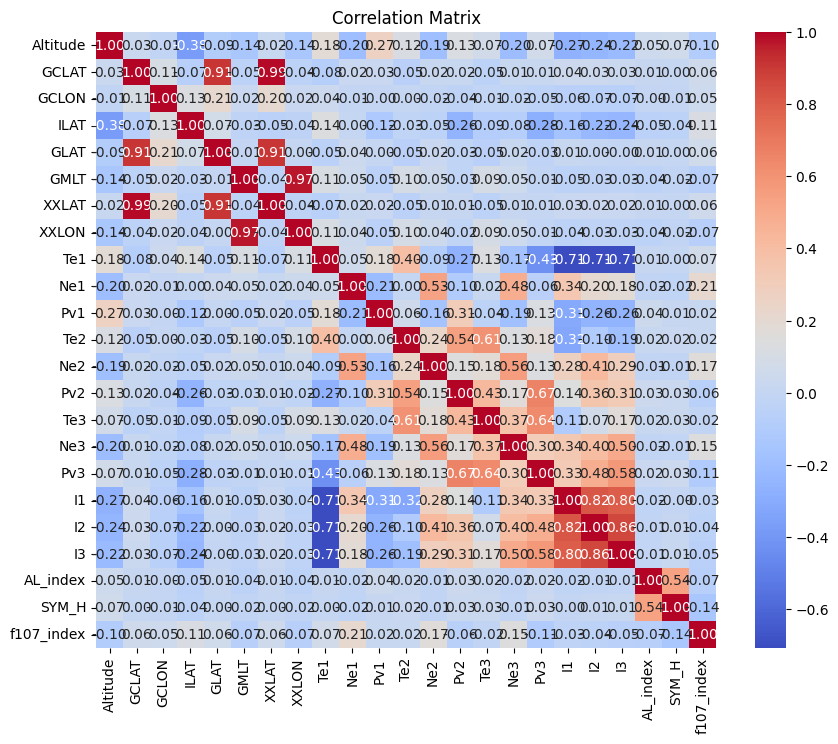

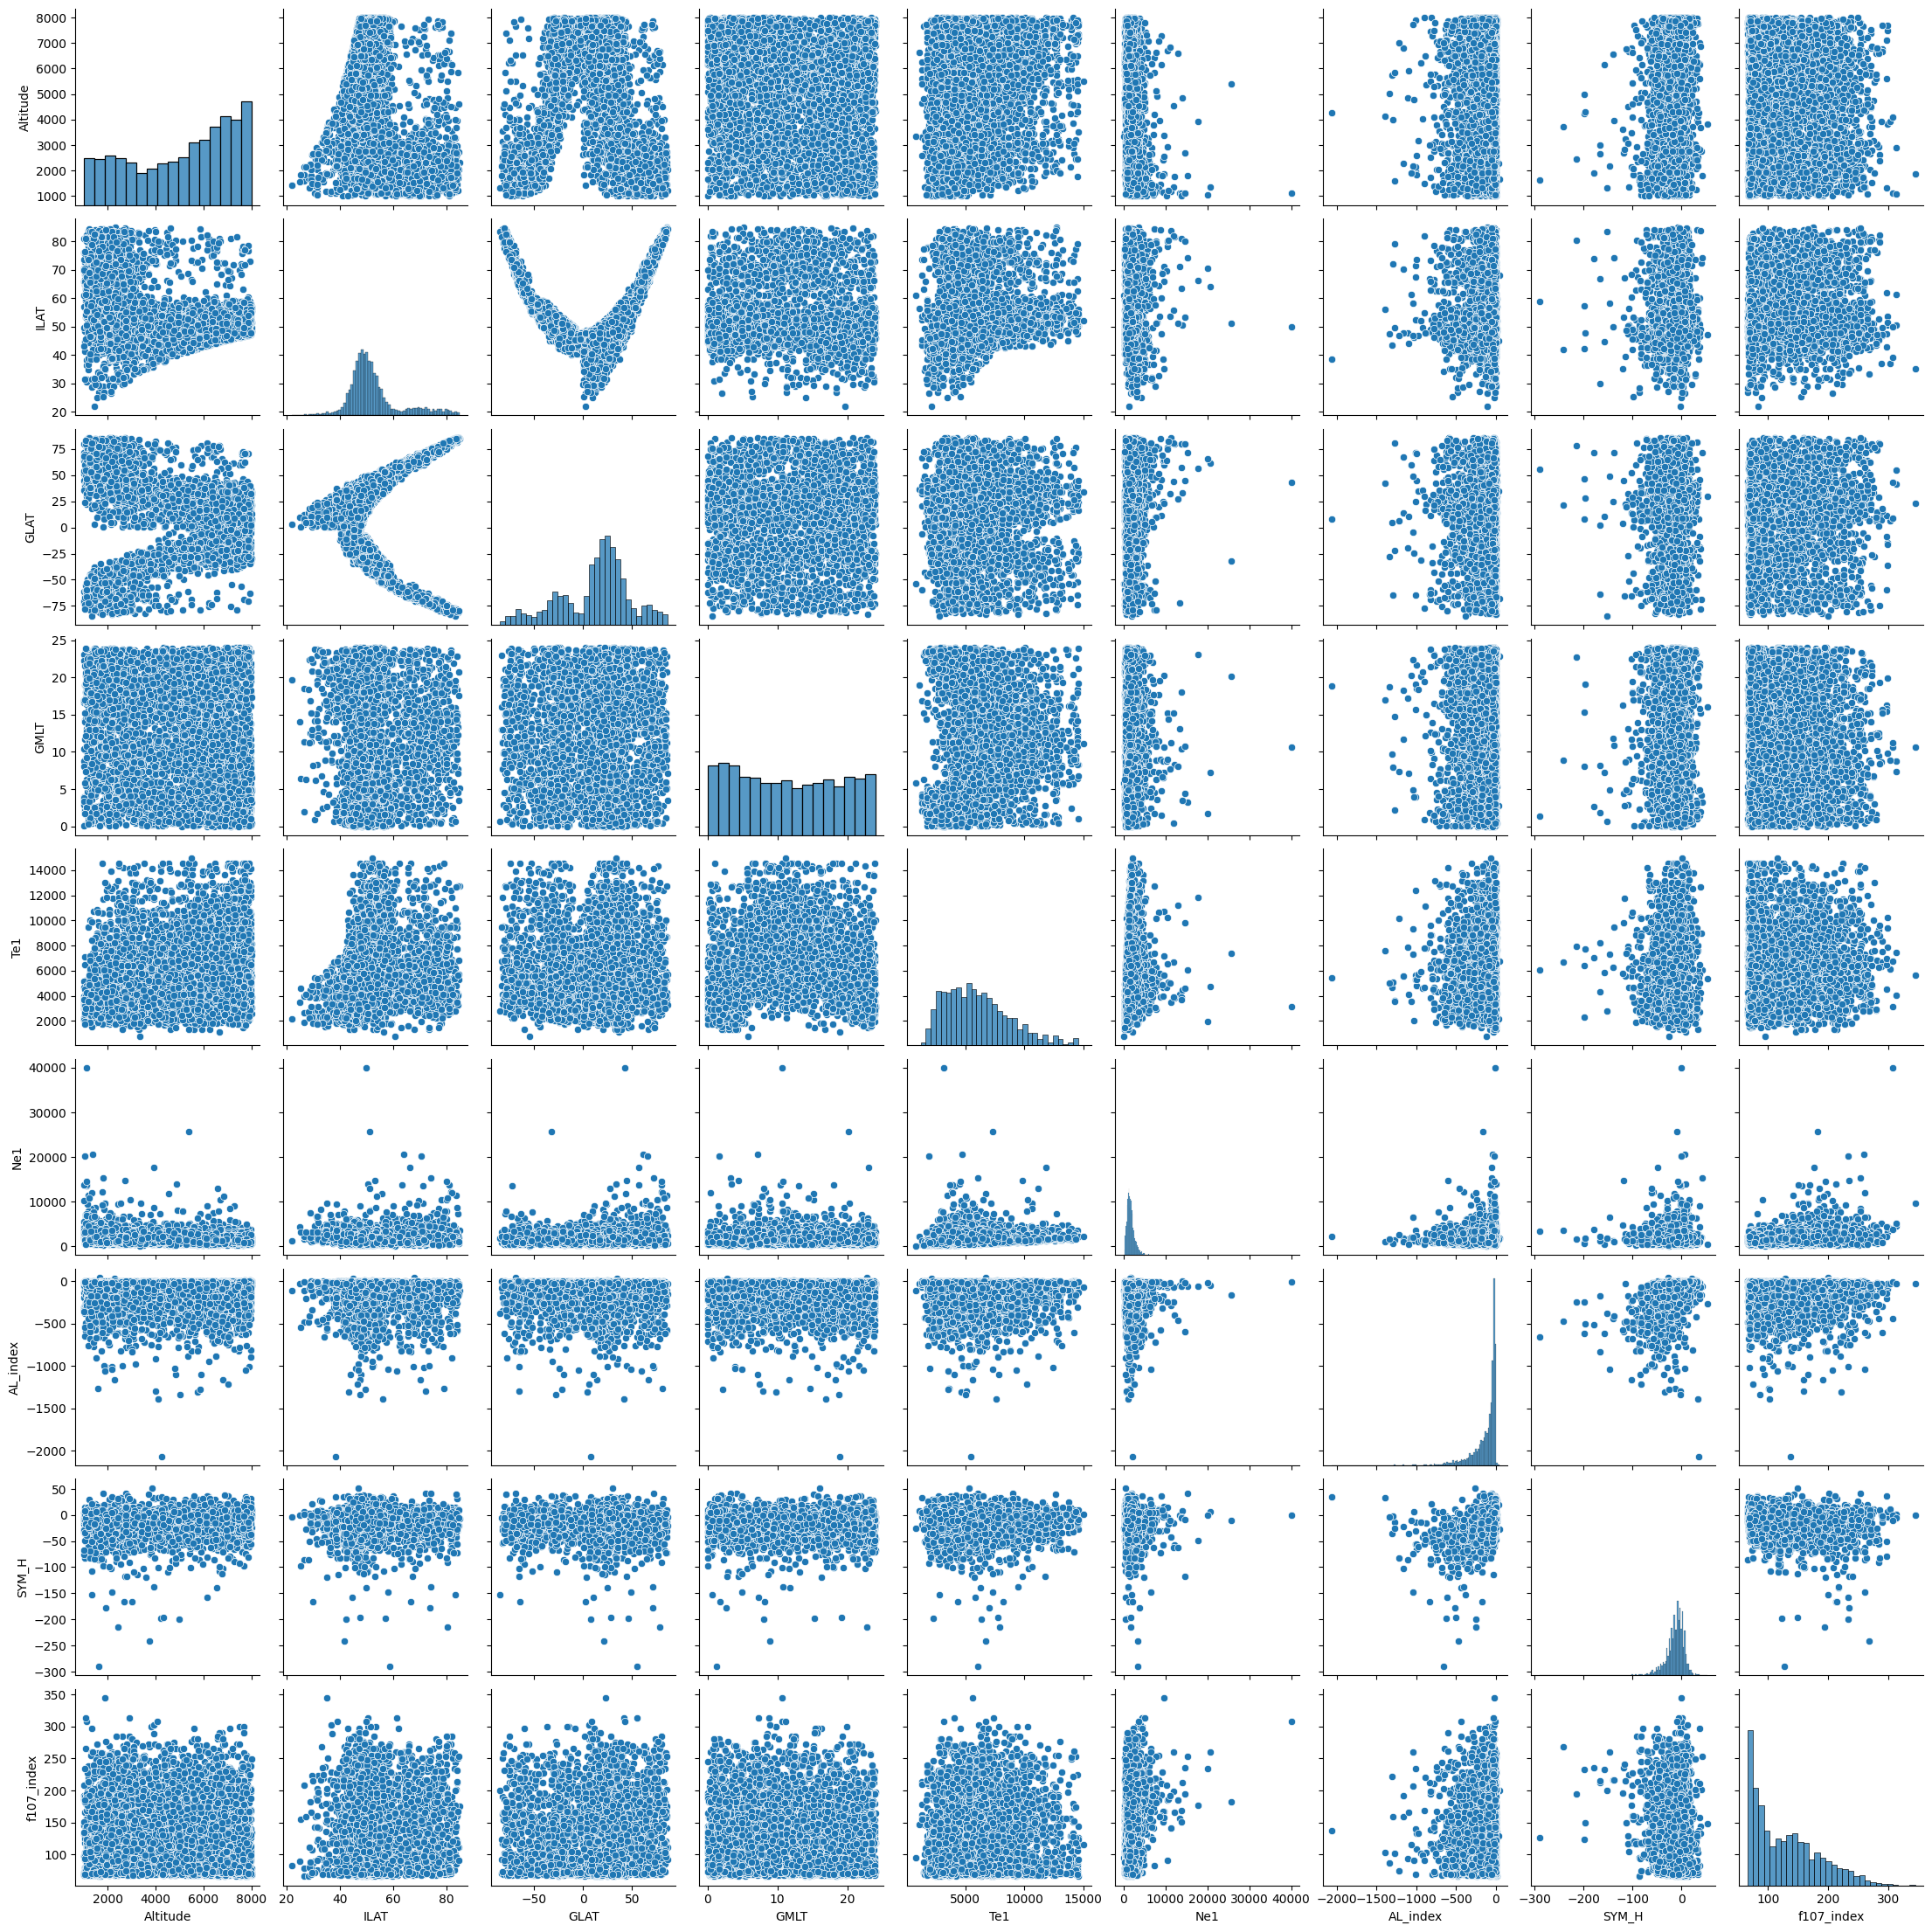


Skewness of Variables:
Altitude       -0.393328
GCLAT          -0.896023
GCLON           0.243101
ILAT            1.290750
GLAT           -0.514870
GMLT            0.080791
XXLAT          -0.868412
XXLON           0.082654
Te1             0.729108
Ne1            16.205235
Pv1            -0.883716
Te2             0.243632
Ne2           117.660837
Pv2            -1.358750
Te3             0.169115
Ne3            26.104662
Pv3            -1.057531
I1              0.509750
I2              0.000342
I3             -0.107606
AL_index       -2.746440
SYM_H          -2.564463
f107_index      0.833167
dtype: float64

Kurtosis of Variables:
Altitude         -1.168390
GCLAT            -0.887114
GCLON            -1.248903
ILAT              1.582787
GLAT             -0.080069
GMLT             -1.300206
XXLAT            -1.024666
XXLON            -1.303039
Te1               0.115319
Ne1            1137.429753
Pv1               2.642071
Te2              -0.236331
Ne2           56308.430755
Pv2        

/tmp/ipykernel_909468/3688868643.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/michael/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


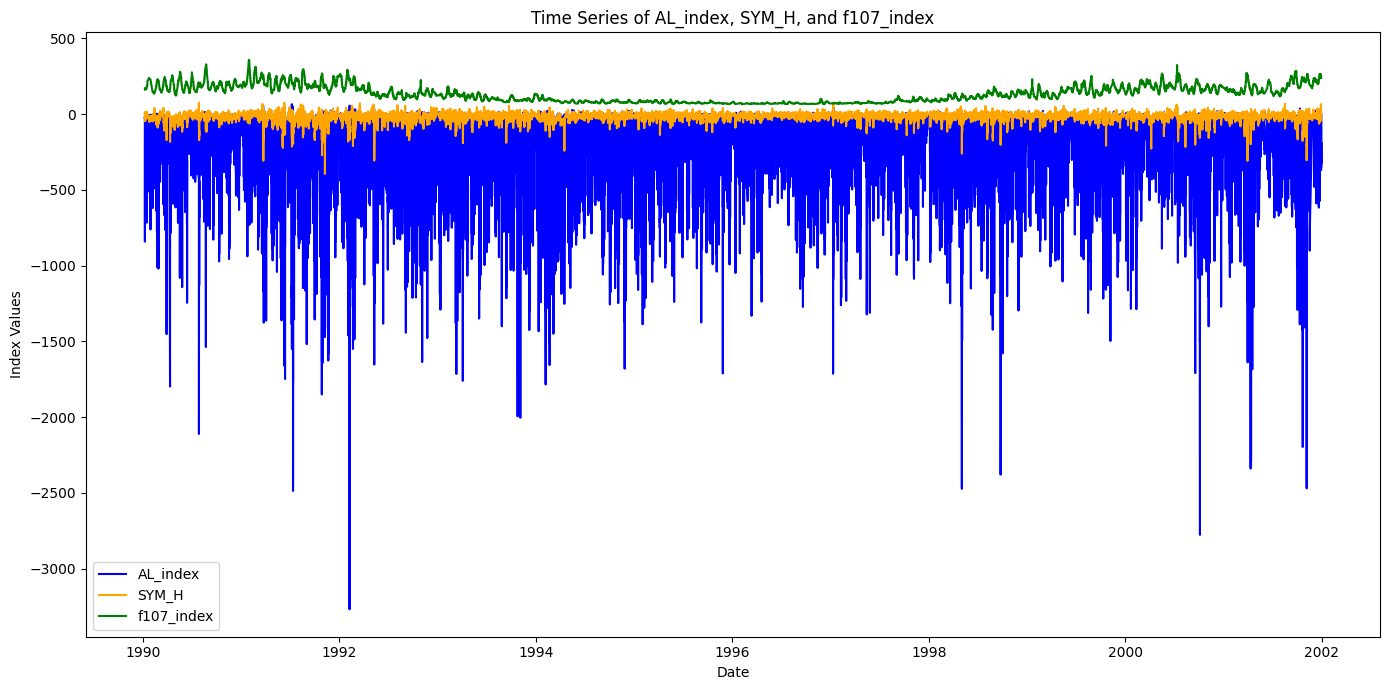

/tmp/ipykernel_909468/3688868643.py:71: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/michael/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


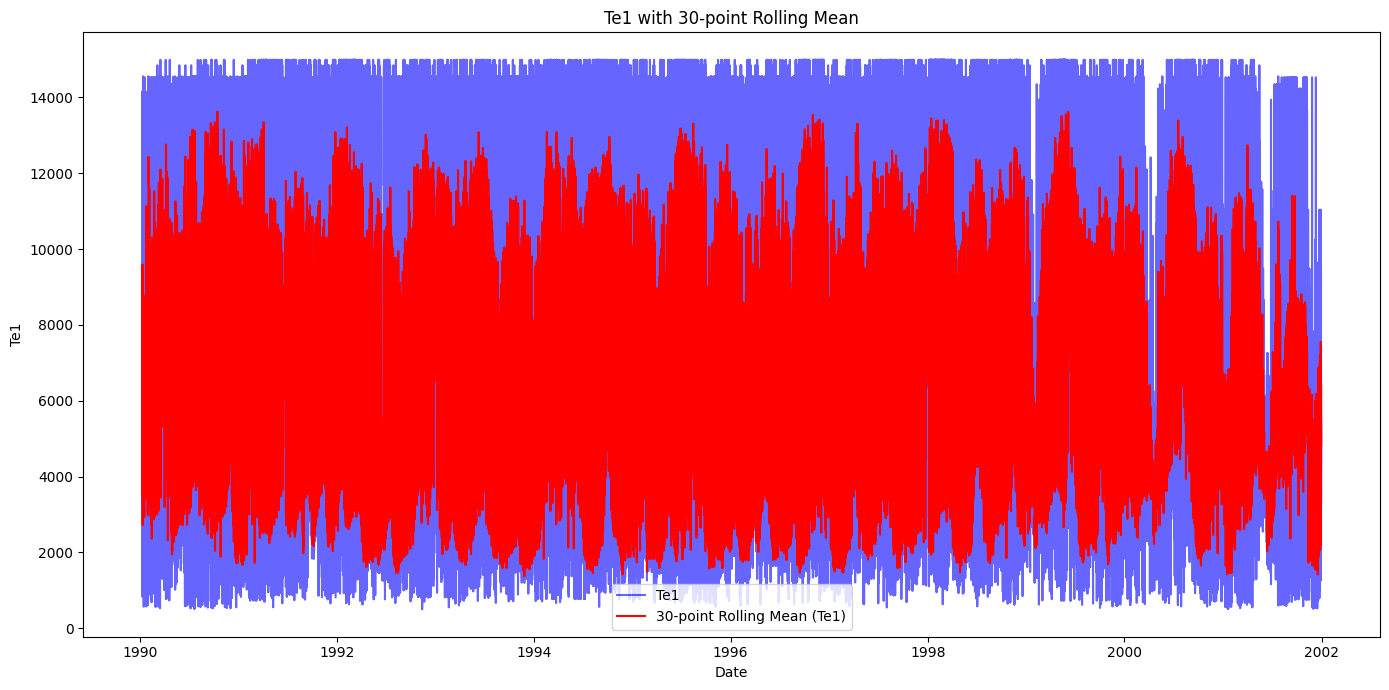

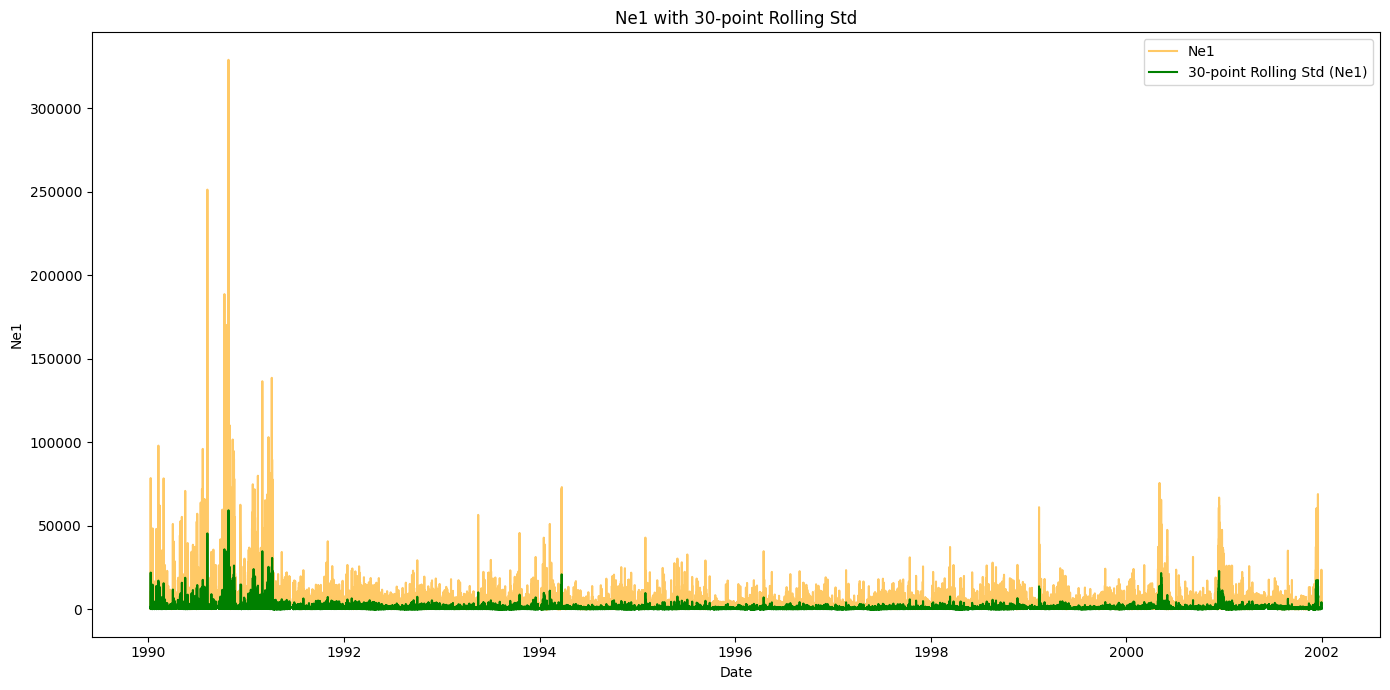

/home/michael/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


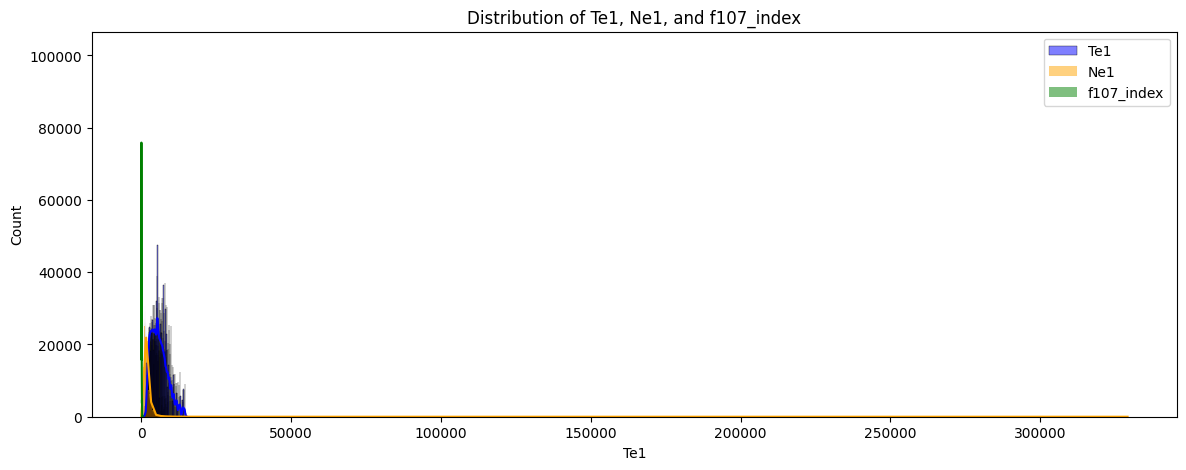


Number of outliers detected: 207495
Indices of detected outliers: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]... (Showing first 10)


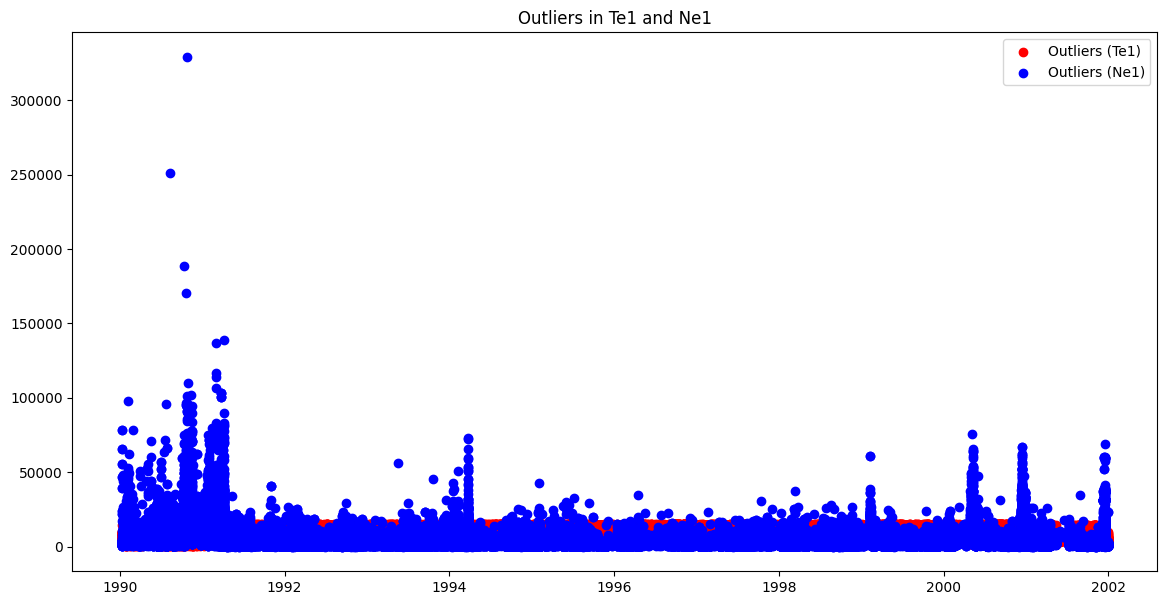

In [8]:
# Assuming 'merged_df' contains the final dataset
# Ensure all numeric columns are in the correct format
numeric_columns = ['Altitude', 'ILAT', 'GLAT', 'GMLT', 'Te1', 'Ne1', 'AL_index', 'SYM_H', 'f107_index']
merged_df[numeric_columns] = merged_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# --- Step 1: Descriptive Statistics ---

# Calculate basic statistics (mean, std, min, max, etc.)
basic_stats = merged_df.describe()
print("Basic Statistics:")
print(basic_stats)

# --- Step 2: Correlation Analysis ---

# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# --- Step 3: Visualizing Relationships between Variables ---

# Pairplot to visualize relationships between variables
sns.pairplot(merged_df[numeric_columns].sample(5000))  # Using a sample for efficiency
plt.show()

# --- Step 6: Evaluating Statistics for Space Weather Forecast Modeling ---

# Evaluate the skewness and kurtosis for all variables
skewness = merged_df.skew()
kurtosis = merged_df.kurt()

print("\nSkewness of Variables:")
print(skewness)

print("\nKurtosis of Variables:")
print(kurtosis)

# --- Step 7: Visualizing Time Series Data ---

# Plot time series for key variables (AL_index, SYM_H, f107_index)
plt.figure(figsize=(14, 7))
plt.plot(merged_df.index, merged_df['AL_index'], label='AL_index', color='blue')
plt.plot(merged_df.index, merged_df['SYM_H'], label='SYM_H', color='orange')
plt.plot(merged_df.index, merged_df['f107_index'], label='f107_index', color='green')
plt.xlabel('Date')
plt.ylabel('Index Values')
plt.title('Time Series of AL_index, SYM_H, and f107_index')
plt.legend()
plt.tight_layout()
plt.show()

# --- Step 8: Rolling Statistics ---

# Compute rolling means and standard deviations for 'Te1' and 'Ne1'
rolling_window = 30  # Example: 30 data points
merged_df['Te1_rolling_mean'] = merged_df['Te1'].rolling(window=rolling_window).mean()
merged_df['Ne1_rolling_std'] = merged_df['Ne1'].rolling(window=rolling_window).std()

# Plot rolling mean and standard deviation for 'Te1' and 'Ne1'
plt.figure(figsize=(14, 7))
plt.plot(merged_df.index, merged_df['Te1'], label='Te1', color='blue', alpha=0.6)
plt.plot(merged_df.index, merged_df['Te1_rolling_mean'], label=f'{rolling_window}-point Rolling Mean (Te1)', color='red')
plt.xlabel('Date')
plt.ylabel('Te1')
plt.title(f'Te1 with {rolling_window}-point Rolling Mean')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(merged_df.index, merged_df['Ne1'], label='Ne1', color='orange', alpha=0.6)
plt.plot(merged_df.index, merged_df['Ne1_rolling_std'], label=f'{rolling_window}-point Rolling Std (Ne1)', color='green')
plt.xlabel('Date')
plt.ylabel('Ne1')
plt.title(f'Ne1 with {rolling_window}-point Rolling Std')
plt.legend()
plt.tight_layout()
plt.show()

# --- Step 9: Distribution Analysis ---

# Visualize the distribution of key variables (Te1, Ne1, f107_index)
plt.figure(figsize=(14, 5))
sns.histplot(merged_df['Te1'].dropna(), kde=True, color='blue', label='Te1')
sns.histplot(merged_df['Ne1'].dropna(), kde=True, color='orange', label='Ne1')
sns.histplot(merged_df['f107_index'].dropna(), kde=True, color='green', label='f107_index')
plt.title('Distribution of Te1, Ne1, and f107_index')
plt.legend()
plt.show()

# --- Step 10: Outlier Detection ---

# Detect outliers using the z-score method
z_scores = np.abs(stats.zscore(merged_df[numeric_columns]))
outliers = np.where(z_scores > 3)  # Z-score threshold for outliers

# Print information about outliers
print(f"\nNumber of outliers detected: {len(outliers[0])}")
outlier_indices = list(set(outliers[0]))
print(f"Indices of detected outliers: {outlier_indices[:10]}... (Showing first 10)")

# Visualize outliers for 'Te1' and 'Ne1'
plt.figure(figsize=(14, 7))
plt.scatter(merged_df.index[outliers[0]], merged_df['Te1'].iloc[outliers[0]], color='red', label='Outliers (Te1)')
plt.scatter(merged_df.index[outliers[0]], merged_df['Ne1'].iloc[outliers[0]], color='blue', label='Outliers (Ne1)')
plt.title('Outliers in Te1 and Ne1')
plt.legend()
plt.show()

